In [1]:
!pip install prophet

In [2]:
from prophet import Prophet
import pandas as pd

In [3]:
data = {
    'ds': pd.to_datetime([
        '2023-04-01', '2023-04-02', '2023-04-03', '2023-04-04', '2023-04-05',
        '2023-04-06', '2023-04-07', '2023-04-08', '2023-04-09', '2023-04-10',
        '2023-04-11', '2023-04-12', '2023-04-13', '2023-04-14', '2023-04-15',
        '2023-04-16', '2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20'
    ]),
    'y': [
        120, 90, 85, 88, 92,
        95, 125, 130, 95, 80,
        80, 250, 320, 280, 150, # ช่วงสงกรานต์ที่คุณยกตัวอย่าง
        90, 85, 88, 91, 94
    ]
}
df = pd.DataFrame(data)

# แสดงข้อมูล 5 แถวแรก
print(df.head())

          ds    y
0 2023-04-01  120
1 2023-04-02   90
2 2023-04-03   85
3 2023-04-04   88
4 2023-04-05   92


In [4]:
holidays = pd.DataFrame({
  'holiday': 'songkran',
  'ds': pd.to_datetime(['2023-04-13']),
  'lower_window': -2,  # ให้เริ่มมีผลกระทบ 2 วันก่อนวันจริง (คือวันที่ 11, 12)
  'upper_window': 1,   # และให้มีผลกระทบต่อไปอีก 1 วันหลังวันจริง (คือวันที่ 14)
})

print(holidays)

    holiday         ds  lower_window  upper_window
0  songkran 2023-04-13            -2             1


In [5]:
model = Prophet(holidays=holidays, weekly_seasonality=True, yearly_seasonality=False)

# สอน Model ด้วยข้อมูลของเรา
model.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyhfl6b6b/2s5ignb7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyhfl6b6b/pzk44ip6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1378', 'data', 'file=/tmp/tmpyhfl6b6b/2s5ignb7.json', 'init=/tmp/tmpyhfl6b6b/pzk44ip6.json', 'output', 'file=/tmp/tmpyhfl6b6b/prophet_modelvy2ajun8/prophet_model-20250917071645.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:16:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:16:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [6]:
future = model.make_future_dataframe(periods=10)

# พยากรณ์
forecast = model.predict(future)

# yhat คือค่าพยากรณ์หลัก
# yhat_lower และ yhat_upper คือช่วงความไม่แน่นอน

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

           ds        yhat  yhat_lower  yhat_upper
25 2023-04-26   83.633438   78.055388   88.797662
26 2023-04-27   85.669056   79.811538   91.352767
27 2023-04-28  114.160657  108.230316  120.223561
28 2023-04-29  120.573018  114.198114  126.842901
29 2023-04-30   77.619273   71.444154   83.997246


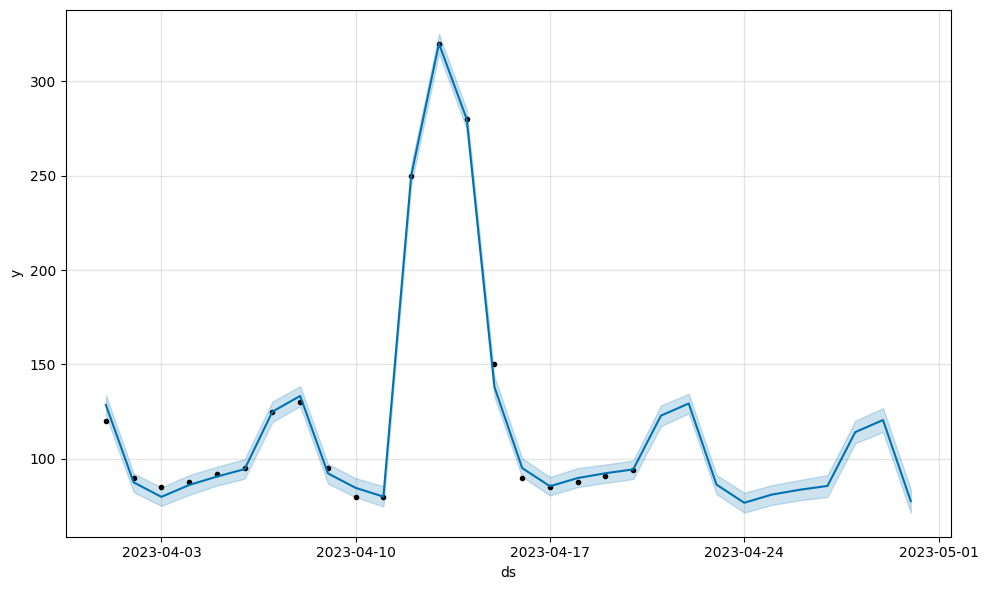

In [7]:
fig1 = model.plot(forecast)

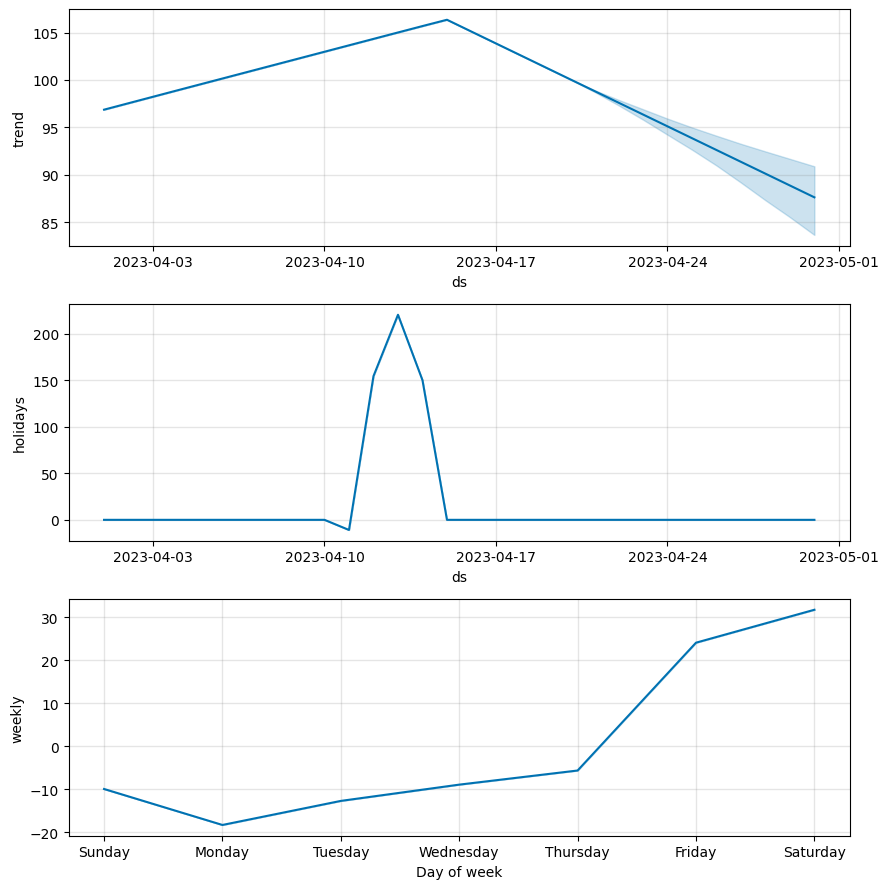

In [8]:
fig2 = model.plot_components(forecast)

In [9]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
date_rng = pd.date_range(start='2023-01-01', end='2024-12-31', freq='D')
df = pd.DataFrame(date_rng, columns=['date'])

In [20]:
df.head()

,date
0,2023-01-01
1,2023-01-02
2,2023-01-03
3,2023-01-04
4,2023-01-05


In [21]:
df.shape

(731, 1)

In [22]:
np.random.seed(42) # เพื่อให้ผลลัพธ์เหมือนกันทุกครั้ง
noise = np.random.randint(0, 15, size=(len(df)))

In [23]:
weekday_effect = df['date'].dt.dayofweek.apply(lambda x: 25 if x >= 5 else 0) # 5=เสาร์, 6=อาทิตย์

In [24]:
time_trend = np.arange(len(df)) * 0.1

In [25]:
df['patients'] = 80 + weekday_effect + time_trend + noise

In [26]:
df.set_index('date', inplace=True)

df.head()

,patients
date,
2023-01-01,111.0
2023-01-02,83.1
2023-01-03,92.2
2023-01-04,94.3
2023-01-05,90.4


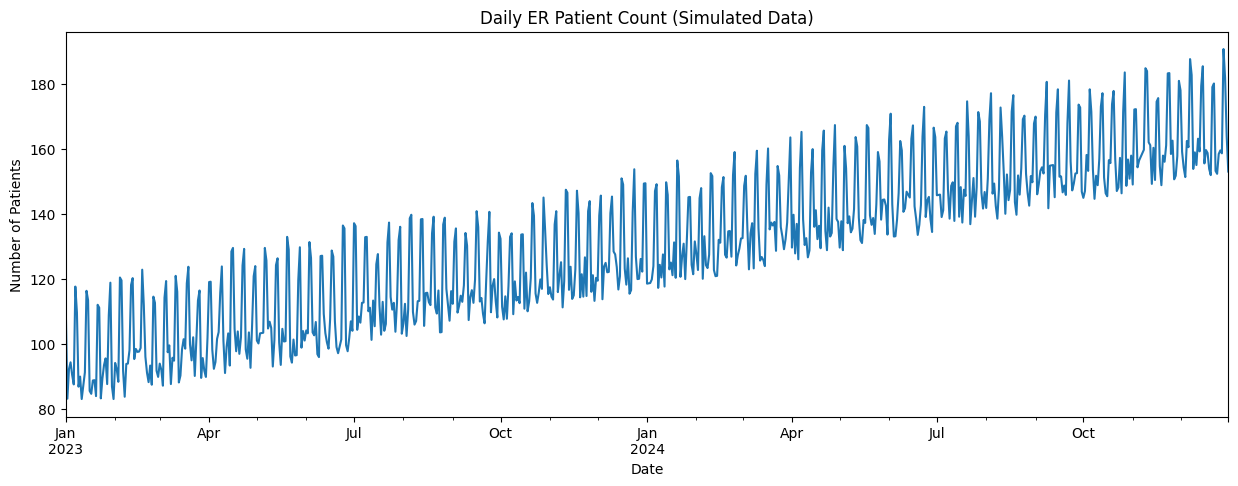

In [27]:
df['patients'].plot(figsize=(15, 5), title='Daily ER Patient Count (Simulated Data)')
plt.xlabel('Date')
plt.ylabel('Number of Patients')
plt.show()

In [28]:
def create_features(df):
    # สร้าง features จาก date

    df['dayofweek'] = df.index.dayofweek # 0 = จันทร์, 6 = อาทิตย์
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear

    # สร้าง Lag Features (ข้อมูลย้อนหลัง)
    # เราจะใช้ข้อมูล 7 วันที่แล้ว และ 14 วันที่แล้วมาช่วยทาย
    df['lag_7'] = df['patients'].shift(7)
    df['lag_14'] = df['patients'].shift(14)

    # สร้าง ค่าเฉลี่ยย้อนหลัง
    df['rolling_mean_7'] = df['patients'].shift(1).rolling(window=7).mean()

    return df

df = create_features(df)

# ข้อมูลจะมีค่าว่าง (NaN) ในช่วงแรกๆ เพราะยังไม่มีข้อมูลย้อนหลังให้คำนวณ
# เราจะลบแถวที่มีค่าว่างทิ้งไป
df.dropna(inplace=True)

df.head()

,patients,dayofweek,quarter,month,dayofyear,lag_7,lag_14,rolling_mean_7
date,,,,,,,,
2023-01-15,113.4,6,1,1,15,109.7,111.0,94.857143
2023-01-16,85.5,0,1,1,16,86.8,83.1,95.385714
2023-01-17,84.6,1,1,1,17,89.9,92.2,95.200000
2023-01-18,88.7,2,1,1,18,83.0,94.3,94.442857
2023-01-19,88.8,3,1,1,19,87.1,90.4,95.257143


In [33]:
FEATURES = ['dayofweek', 'quarter', 'month', 'dayofyear', 'lag_7', 'lag_14', 'rolling_mean_7']
TARGET = 'patients'

In [34]:
X = df[FEATURES]
y = df[TARGET]

In [35]:
split_date = '2024-10-01'
X_train, X_test = X.loc[X.index < split_date], X.loc[X.index >= split_date]
y_train, y_test = y.loc[y.index < split_date], y.loc[y.index >= split_date]

In [32]:
print(f"Train set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Train set: 625 samples
Test set: 92 samples


In [36]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [37]:
# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100,
                             learning_rate=0.05, # ค่อยๆ เรียนรู้ช้าๆ
                             early_stopping_rounds=10, # ถ้าผลไม่ดีขึ้น 10 รอบให้หยุด
                             random_state=42)

In [38]:
# XGBoost ต้องมี evaluation set เพื่อใช้ early stopping
xgb_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [39]:
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

In [40]:
rf_mae = mean_absolute_error(y_test, rf_pred)
xgb_mae = mean_absolute_error(y_test, xgb_pred)

In [41]:
print(f"\nความคลาดเคลื่อนเฉลี่ยของ Random Forest: {rf_mae:.2f} คน")
print(f"ความคลาดเคลื่อนเฉลี่ยของ XGBoost: {xgb_mae:.2f} คน")


ความคลาดเคลื่อนเฉลี่ยของ Random Forest: 5.54 คน
ความคลาดเคลื่อนเฉลี่ยของ XGBoost: 6.59 คน


In [42]:
results = pd.DataFrame({
    'Actual': y_test,
    'Random Forest': rf_pred,
    'XGBoost': xgb_pred
})

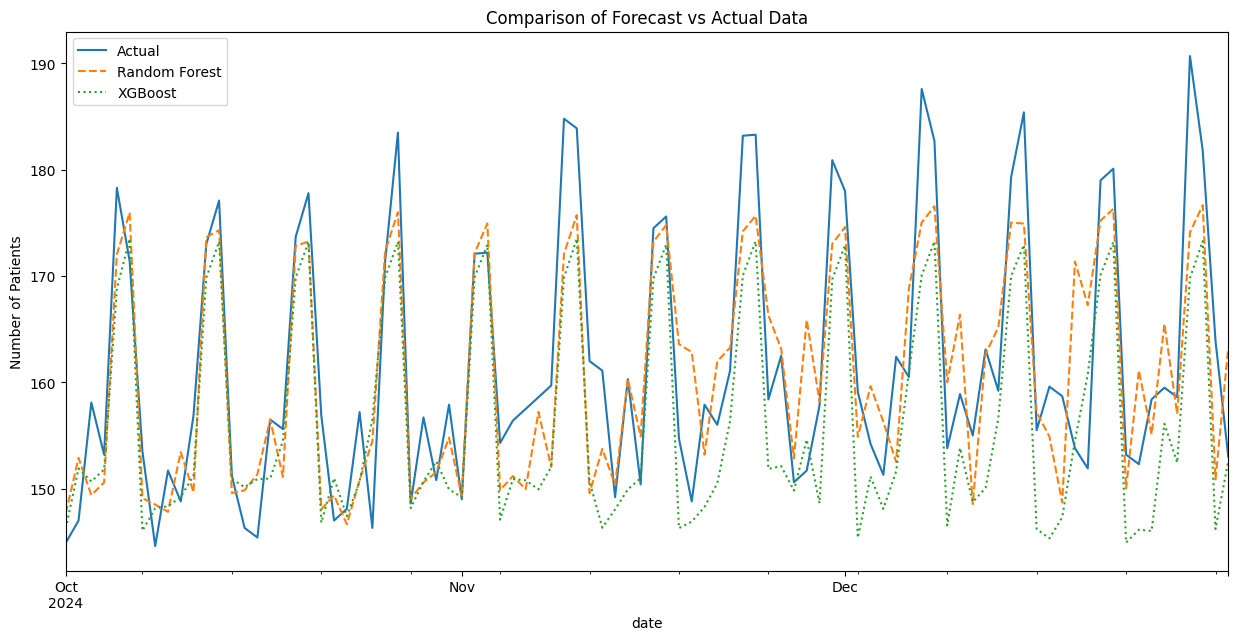

In [43]:
results.plot(figsize=(15, 7), style=['-', '--', ':'],
             title='Comparison of Forecast vs Actual Data')
plt.ylabel('Number of Patients')
plt.show()

In [44]:
def plot_feature_importance(model, features, model_name):
    # สร้าง DataFrame ของ feature importance
    fi = pd.DataFrame(data=model.feature_importances_,
                      index=features,
                      columns=['importance'])
    fi_sorted = fi.sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=fi_sorted.index, y=fi_sorted['importance'])
    plt.title(f'Feature Importance of the {model_name} Model') # Changed title to English
    plt.xticks(rotation=45)
    plt.xlabel('Features') # Added x-axis label
    plt.show()

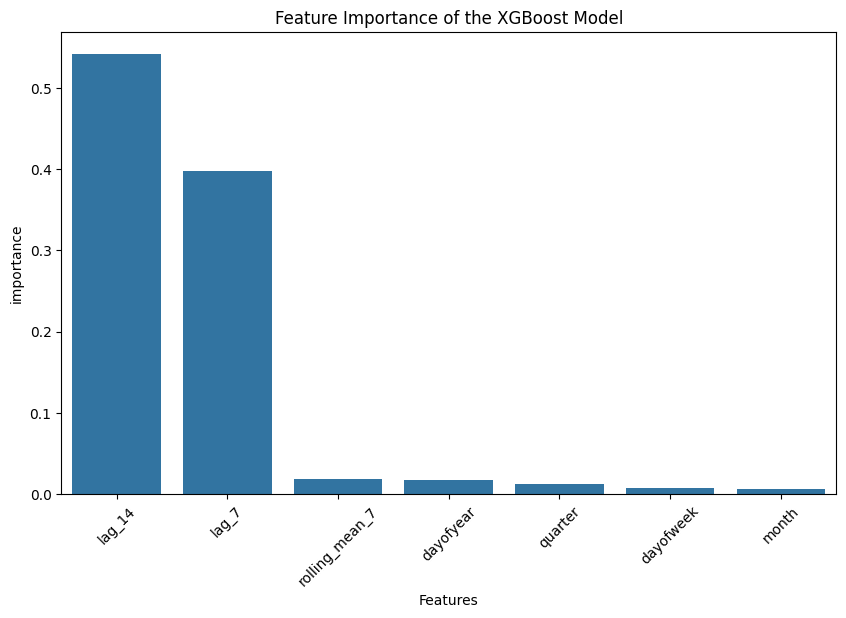

In [45]:
plot_feature_importance(xgb_model, FEATURES, 'XGBoost')

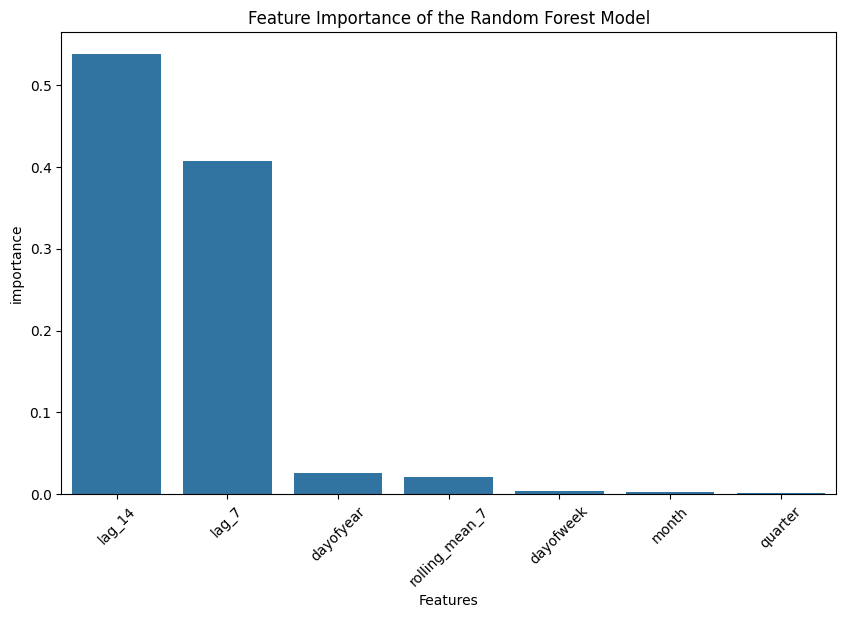

In [46]:
plot_feature_importance(rf_model, FEATURES, 'Random Forest')

In [47]:
pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-p_96di87
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-p_96di87
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit fcd09fe8b6bf57643bde7847bf42a6719b7ee205
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for chronos-forecasting: filename=chronos_forecasting-1.5.3-py3-none-any.whl size=29457 sha256=1ed17963a7cb042bbb2bbd927e0f5c26133b09dc77300086832dedd8cf911cd2
  Stored in directory: /tmp/pip-ephem-wheel-cache-ikb_cfyp/wheels/b9/a6/b5/75fca7306751a3bc92a63680f861f44a42a8776f6423cf0188
Successfully built chronos-forecasting


In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

In [49]:
pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-small",
  device_map="cuda",
  dtype=torch.bfloat16,
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/185M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

In [60]:
df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")

In [53]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [54]:
df.shape

(144, 1)

In [61]:
context = torch.tensor(df["#Passengers"])
prediction_length = 12
forecast = pipeline.predict(context, prediction_length)

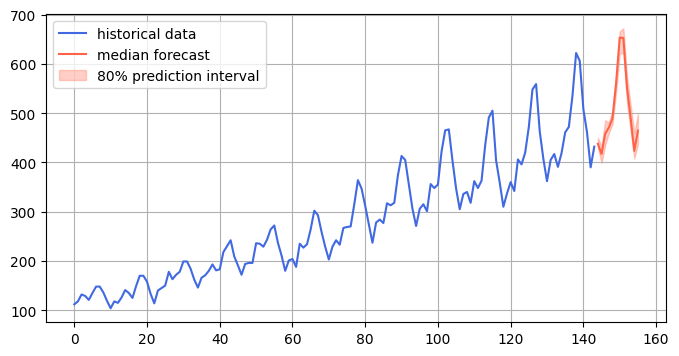

In [62]:
forecast_index = range(len(df), len(df) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(df["#Passengers"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

In [63]:
forecast[0][:][0]

tensor([439.7647, 417.1600, 476.7542, 491.1391, 515.7988, 563.0632, 643.2072,
        659.6470, 548.6784, 497.3040, 425.3799, 464.4244])

In [64]:
# คำนวณค่ามัธยฐานของผลการพยากรณ์ในแต่ละช่วงเวลา
median_forecast = np.median(forecast[0], axis=0)

print("ค่ามัธยฐานของผลการพยากรณ์ 12 เดือนข้างหน้า")
print(median_forecast)

ค่ามัธยฐานของผลการพยากรณ์ 12 เดือนข้างหน้า
[437.70972 417.15997 458.25946 470.58932 489.0841  559.9807  653.48206
 652.4546  551.76086 490.11157 423.3249  464.42438]
